## Nonlinear Regression Examples

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import eval_chebyt, eval_legendre

In [2]:
class Zonotope:
    def __init__(self, centre, generators):
        self.centre = np.array(centre).reshape(-1)
        self.generators = np.atleast_2d(generators)
        if self.generators.shape[0] != self.centre.shape[0]:
            raise ValueError("Generators must have same dimension as centre")
        self.n = self.centre.shape[0]   # dimension
        self.m = self.generators.shape[1]  # number of generators

    def minkowski_sum(self, other):
        new_centre = self.centre + other.centre
        new_generators = np.hstack((self.generators, other.generators))
        return Zonotope(new_centre, new_generators)
    
    def output_interval(self):
        radius = np.sum(np.abs(self.generators), axis=1)  # sum across generators
        lower = self.centre - radius
        upper = self.centre + radius
        return lower, upper

    def affine_map(self, A, b=None):
        new_centre = A @ self.centre + (b if b is not None else 0)
        new_generators = A @ self.generators 
        return Zonotope(new_centre, new_generators)

### Data Functions

In [3]:
def nonlinear_data(n):
    n_samples = n
    x = np.random.rand(n_samples)
    w = np.random.normal(0, 0.025, n_samples)
    y = 0.3 * (15 * x * np.exp(-3 * x) + w * x)
    y_radius = (1/160) * (np.abs(x - 2) + 0.5)
    y_lower = y - y_radius
    y_upper = y + y_radius

    x_grid = np.linspace(0, 10, n_samples)

    return n_samples, x, y, y_lower, y_upper, x_grid

def artificial_dataset_1(n):
    n_samples = n
    x = np.random.rand(n_samples)
    
    noise = np.random.normal(0, 0.15, n_samples)
    y = np.sin(2 * np.pi * x**2) * np.exp(-x) + 1 + noise
    
    y_radius = np.abs(np.random.normal(0.1, 0.05, n_samples))
    
    y_lower = y - y_radius
    y_upper = y + y_radius
    
    x_grid = np.linspace(0, 1, n_samples)
    
    return n_samples, x, y, y_lower, y_upper, x_grid


def artificial_dataset_2(n):
    n_samples = n
    x = np.random.rand(n_samples)
    
    noise = np.random.normal(0, 0.02, n_samples)
    y = 5 * x * np.exp(-3 * x) + 0.25 + noise
    
    y_radius = 0.2 * np.exp(-10 * (x - 0.7)**2)
    
    y_lower = y - y_radius
    y_upper = y + y_radius
    
    x_grid = np.linspace(0, 1, n_samples) 
    
    return n_samples, x, y, y_lower, y_upper, x_grid

### Bounds Functions

In [4]:


def chebyshev_basis(X, degree=5):
    X = np.asarray(X).flatten()
    X_scaled = 2*(X - X.min()) / (X.max() - X.min()) - 1
    Phi = np.column_stack([eval_chebyt(i, X_scaled) for i in range(degree+1)])
    return Phi

def legendre_basis(X, degree=5):
    X = np.asarray(X).flatten()
    X_scaled = 2*(X - X.min()) / (X.max() - X.min()) - 1
    Phi = np.column_stack([eval_legendre(i, X_scaled) for i in range(degree+1)])
    return Phi

def polynomial_basis(X, degree=5):
    X = np.asarray(X).flatten()
    X_scaled = (X - X.min()) / (X.max() - X.min())
    Phi = np.column_stack([X_scaled**i for i in range(degree+1)])
    return Phi


def nonlinear_zonotope_bounds(X, y_lower, y_upper, x_grid=None, degree=10, basis='chebyshev'):
    X = np.asarray(X).flatten()
    y_lower = np.asarray(y_lower).flatten()
    y_upper = np.asarray(y_upper).flatten()
    
    centre_y = (y_lower + y_upper) / 2
    radii_y = (y_upper - y_lower) / 2
    
    basis_functions = {
        'chebyshev': chebyshev_basis,
        'legendre': legendre_basis,
        'polynomial': polynomial_basis,
    }
    
    Phi = basis_functions[basis](X, degree)
    
    M = np.linalg.solve(Phi.T @ Phi, Phi.T)
    
    # Create zonotope in output space
    Y_zono = Zonotope(centre_y, np.diag(radii_y))
    
    # Map to parameter space
    Beta_zono = Y_zono.affine_map(M)
    
    if x_grid is not None:
        Phi_grid = basis_functions[basis](x_grid, degree)
        # Map back to output space on grid
        Yhat_zono = Beta_zono.affine_map(Phi_grid)
        y_lower_pred, y_upper_pred = Yhat_zono.output_interval()
        return Beta_zono, Yhat_zono, y_lower_pred, y_upper_pred
    
    return Beta_zono


def nonlinear_bounds_monte_carlo(X, y_lower, y_upper, x_grid=None, degree=10, 
                                  basis='chebyshev', n_samples=10000):

    X = np.asarray(X).flatten()
    y_lower = np.asarray(y_lower).flatten()
    y_upper = np.asarray(y_upper).flatten()
    
    basis_functions = {
        'chebyshev': chebyshev_basis,
        'legendre': legendre_basis,
        'polynomial': polynomial_basis,
    }

    
    Phi = basis_functions[basis](X, degree)
    
    M = np.linalg.solve(Phi.T @ Phi, Phi.T)

    y_samples = np.random.uniform(y_lower[:, None], y_upper[:, None], 
                                   size=(len(y_lower), n_samples))
    

    beta_samples = M @ y_samples 
    beta_samples = beta_samples.T
    
    if x_grid is not None:
        x_grid = np.asarray(x_grid).flatten()
        Phi_grid = basis_functions[basis](x_grid, degree)
        
        y_pred_samples = Phi_grid @ beta_samples.T
    
        y_lower_pred = np.min(y_pred_samples, axis=1)
        y_upper_pred = np.max(y_pred_samples, axis=1)
        
        return beta_samples, y_pred_samples.T, y_lower_pred, y_upper_pred
    
    return beta_samples

### Results

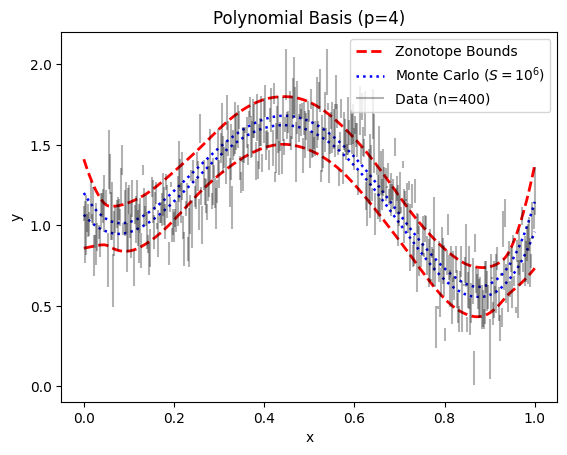

In [5]:
n, x, y, y_lower, y_upper, x_grid = artificial_dataset_1(400)

_, y_pred, y_min, y_max = nonlinear_zonotope_bounds(x, y_lower, y_upper, x_grid, degree=4, basis='polynomial')
_, _, y_min_mc, y_max_mc = nonlinear_bounds_monte_carlo(x, y_lower, y_upper, x_grid, degree=4, basis='polynomial', n_samples=1000000)


idx = np.argsort(x)
x_sorted = x[idx]
y_lower_sorted = y_lower[idx]
y_upper_sorted = y_upper[idx]


plt.plot(x_grid, y_min, '--r', label='Zonotope Bounds', linewidth=2)
plt.plot(x_grid, y_max, '--r', linewidth=2)

plt.plot(x_grid, y_min_mc, ':b', label=r'Monte Carlo ($S=10^{6}$)', linewidth=1.8)
plt.plot(x_grid, y_max_mc, ':b', linewidth=1.8)


plt.vlines(x_grid, y_lower_sorted, y_upper_sorted, color='black', alpha=0.3, label='Data (n=400)')
plt.legend()
plt.title('Polynomial Basis (p=4)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

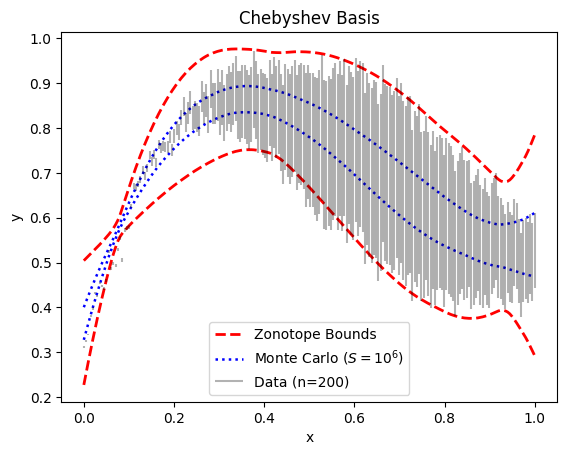

In [6]:
n, x, y, y_lower, y_upper, x_grid = artificial_dataset_2(200)

_, y_pred, y_min, y_max = nonlinear_zonotope_bounds(x, y_lower, y_upper, x_grid, degree=3, basis='chebyshev')
_, _, y_min_mc, y_max_mc = nonlinear_bounds_monte_carlo(x, y_lower, y_upper, x_grid, degree=3, basis='chebyshev', n_samples=1000000)
#_, (y_naive_min, y_naive_max) = naive_interval_bounds(x, y_lower, y_upper, x_grid, degree=10)


idx = np.argsort(x)
x_sorted = x[idx]
y_lower_sorted = y_lower[idx]
y_upper_sorted = y_upper[idx]

plt.plot(x_grid, y_min, '--r', label='Zonotope Bounds', linewidth=2)
plt.plot(x_grid, y_max, '--r', linewidth=2)

plt.plot(x_grid, y_min_mc, ':b', label=r'Monte Carlo ($S=10^{6}$)', linewidth=1.8)
plt.plot(x_grid, y_max_mc, ':b', linewidth=1.8)


plt.vlines(x_grid, y_lower_sorted, y_upper_sorted, color='black', alpha=0.3, label='Data (n=200)')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Chebyshev Basis')
plt.show()